In [1]:
import torch
import numpy as np
import pandas as pd

import sklearn.utils
import sklearn.gaussian_process
import matplotlib.pyplot as plt

In [2]:
class One_D_Datasets(torch.utils.data.Dataset):
    """
    Dataset of one-dimensional functions, generated from varying gaussian processes for testing my NPR methods

    Parameters
    ----------
    num_samples: how many samples from family to collect

    n_same_samples: how many samples to collect with the same hyper-parameters

    n_points: how many points to to sample the process at within range, X

    min_max: tuple, min_max x range to evaluate the gaussian process at

    kernel: kernels for gaussian process regression. Can be ['RBF()', 'ConstantKernel()', 'DotProduct()', 'ExpSineSquared()', 'Matern()', 'WhiteKernel()']

    vary_kernel_hyp: do we vary kernel hyperparameters or nah?
    
    **kwargs: additional arguments to GaussianProcessRegressor
    """
    def __init__(self,
                 num_samples = 10000,
                 n_same_samples = 20,
                 n_points =      128,
                 min_max  =   (-2,2),
                 kernel   = sklearn.gaussian_process.kernels.RBF(length_scale = 0.4, length_scale_bounds = (0.01,1)),
                 vary_kernel_hyp = True,
                 **kwargs
    ):
        super().__init__()
        self.n_points = n_points
        self.num_samples = num_samples
        self.n_same_samples = n_same_samples
        self.min_max = min_max
        self.is_vary_kernel_hyp = vary_kernel_hyp

        if not vary_kernel_hyp:
            # only fit hyperparam when predicting if using various hyperparam
            kwargs["optimizer"] = None

            # we also fix the bounds as these will not be needed
            for hyperparam in kernel.hyperparameters:
                kernel.set_params(**{f"{hyperparam.name}_bounds": "fixed"})

        self.generator = sklearn.gaussian_process.GaussianProcessRegressor(kernel = kernel, alpha=0.005, **kwargs)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def vary_kernel_hyperparam(self):
        K = self.generator.kernel
        for hyperparam in K.hyperparameters:
            K.set_params(
                **{hyperparam.name: np.random.uniform(*hyperparam.bounds.squeeze())}
            )

    def get_samples(
        self,
        n_samples,
        test_min_max,
        n_points
    ):
        test_min_max = test_min_max if test_min_max is not None else self.min_max
        n_points = n_points if n_points is not None else self.n_points
        n_samples = n_samples if n_samples is not None else self.num_samples
        """
        n_samples: number of samples to generate data for
        test_min_max: range of x values to generate sample for
        n_points: number of points to generate 
        """
        X = self._sample_features(test_min_max, n_points, n_samples)

        self.data, self.targets = self._sample_targets(X, n_samples)

        return self.data, self.targets
        

    def _sample_features(self, min_max, n_points, n_samples):
        X = np.random.uniform(min_max[1], min_max[0], size=(n_samples, n_points))
        X.sort(axis=-1)
        return X

    def _sample_targets(self, X, n_samples):
        targets = X.copy()
        n_samples, n_points = X.shape
        for i in range(0, n_samples, self.n_same_samples):
            if self.is_vary_kernel_hyp:
                self.vary_kernel_hyperparam()
            for attempt in range(self.n_same_samples):
                try:
                    n_same_samples = targets[i:i+self.n_same_samples,:].shape[0]
                    targets[i:i+self.n_same_samples,:] = self.generator.sample_y(
                        X[i+attempt,:,np.newaxis],
                        n_samples = n_same_samples,
                        random_state = None,
                    ).transpose(1,0)
                    X[i:i+self.n_same_samples,:] = X[i+attempt,:]
                except np.linalg.LinAlgError:
                    continue
                else:
                    break
        X, targets = sklearn.utils.shuffle(X, targets)
        targets = torch.from_numpy(targets)
        targets = targets.view(n_samples, n_points, 1).float()
        return X, targets
            
        
            
                 

In [3]:
test_one_d_datasets = One_D_Datasets(
    kernel = sklearn.gaussian_process.kernels.RBF(length_scale_bounds=(0.1, 2)) 
)

val_one_d_datasets = One_D_Datasets(
    num_samples = 1000,
    kernel = sklearn.gaussian_process.kernels.RBF(length_scale_bounds=(0.1, 2)) 
)

In [4]:
test_one_d_datasets.get_samples(None, None, None)
val_one_d_datasets.get_samples(None, None, None)

(array([[-1.97200746, -1.9188915 , -1.91825755, ...,  1.95065497,
          1.97427344,  1.98456615],
        [-1.97405115, -1.92299025, -1.91576108, ...,  1.91705306,
          1.96268118,  1.98215738],
        [-1.97808694, -1.95072169, -1.94552725, ...,  1.8690865 ,
          1.90432299,  1.96194919],
        ...,
        [-1.97694885, -1.93105531, -1.92579819, ...,  1.90980519,
          1.93692067,  1.99859263],
        [-1.96484042, -1.91127874, -1.90911961, ...,  1.84954834,
          1.93210638,  1.96906051],
        [-1.97191729, -1.94390575, -1.92538156, ...,  1.94306374,
          1.9560107 ,  1.95695128]]),
 tensor([[[-1.1224],
          [-1.1088],
          [-1.1086],
          ...,
          [ 1.5343],
          [ 1.5307],
          [ 1.5291]],
 
         [[-1.0937],
          [-1.3973],
          [-1.4358],
          ...,
          [-0.0969],
          [-0.1039],
          [-0.1107]],
 
         [[ 0.9457],
          [ 0.9330],
          [ 0.9306],
          ...,
       

In [5]:
len(val_one_d_datasets)

1000

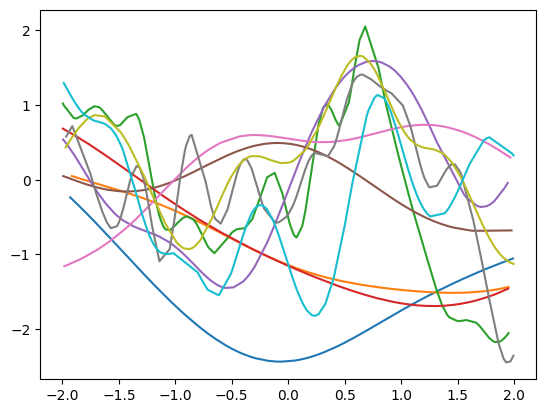

In [6]:
for i in range(10):
    X, Y = test_one_d_datasets[i]
    plt.plot(X,Y)

In [7]:
from architecture_classes import *
from utils import *
import torch
from NeuralProcessClasses_Regression import *

In [8]:
MLP.__doc__

In [9]:
encoder = MLP(2,[128,128,128,128])
decoder = MLP(129,[128,128,128,128])

one_d_cnp = ConditionalNeuralProcess(encoder, decoder, 128,1)

In [10]:
one_d_cnp

ConditionalNeuralProcess(
  (encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inplace=False)
      (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
      (relu_3): ReLU()
      (dropout_3): Dropout(p=0.1, inplace=False)
      (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
      (relu_4): ReLU()
      (dropout_4): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=129, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inplace=False)
    

In [12]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

min_context = int(test_one_d_datasets.n_points*0.1)
max_context = int(test_one_d_datasets.n_points*0.9)
len_seq = int(test_one_d_datasets.n_points)

EPOCHS=50
one_d_cnp.train()
optim = torch.optim.Adam(one_d_cnp.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

val_loader = torch.utils.data.DataLoader(val_one_d_datasets, batch_size = len(val_one_d_datasets), shuffle=False)
for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(test_one_d_datasets, batch_size=32, shuffle=True)
    
    for i, batch in enumerate(loader):
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
        #adjust_learning_rate(optim, global_step)
        
        y_pred_mu,y_pred_var, loss = one_d_cnp(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    for batch in val_loader:
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
        y_pred_mu,y_pred_var, val_loss = one_d_cnp(x_context, y_context, x_target, y_target)

        print(val_loss.item())

86.85791015625
73.07188415527344
53.41987228393555
49.053672790527344
22.86870002746582
0.6183720827102661
52.47551727294922
3.1841206550598145
60.78249740600586
-16.296396255493164
-20.023670196533203
-11.772130012512207
-22.037900924682617
6.284169673919678
-25.098529815673828
-10.022200584411621
7.468539237976074
-20.50263214111328
-36.42884826660156
-27.327552795410156
-31.795333862304688
-13.41098403930664
-28.670934677124023
12.658373832702637
-40.872802734375
-34.813819885253906
-41.92304229736328
-40.12901306152344
-40.140113830566406
-32.84978485107422
-7.381718635559082
-30.263355255126953
-47.44944381713867
-38.57249069213867
-33.43278503417969
-45.96044158935547
-41.489505767822266
-44.25056076049805
-15.20212173461914
-48.692779541015625
-47.703529357910156
-40.41123580932617
-51.20627212524414
-41.940860748291016
-44.909423828125
-51.57325744628906
-40.958614349365234
-47.86548614501953
-55.17378234863281
-57.54719924926758


In [32]:
for i, batch in tqdm(enumerate(loader)):
        
    #global_step+=1
    (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
    break

0it [00:00, ?it/s]


In [33]:
mu, var, likelihood = one_d_cnp(x_context, y_context, x_target, y_target)

In [34]:
x_context.shape

torch.Size([32, 29, 1])

In [35]:
x_context[:,0].shape

torch.Size([32, 1])

In [36]:
detached_mu = mu.detach().numpy()
detached_var = var.detach().numpy()

lower_bounds = detached_mu - detached_var
upper_bounds = detached_mu + detached_var

full_results = np.concatenate([x_target.numpy(), detached_mu, lower_bounds, upper_bounds], axis=2)


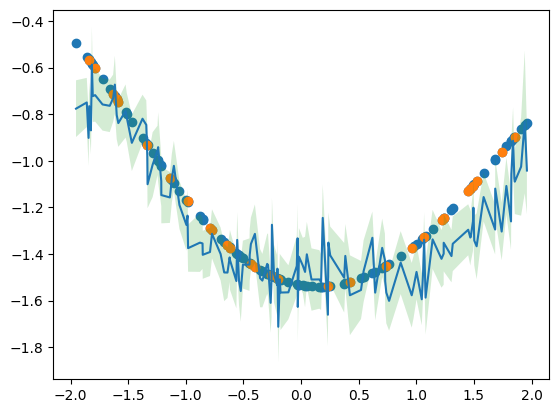

In [42]:
index_of_interest = 4
plt.scatter(x_target[index_of_interest], y_target[index_of_interest])
plt.scatter(x_context[index_of_interest], y_context[index_of_interest])

plt.plot(
    full_results[index_of_interest , full_results[index_of_interest , :, 0].argsort(), 0],
    full_results[index_of_interest , full_results[index_of_interest , :, 0].argsort(), 1]
)

plt.fill_between(
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 0],
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 2],
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 3],
    interpolate=True,
    alpha=0.2
)

In [43]:
deterministic_encoder = MLP(2,[128,128,128,128])
latent_encoder = MLP(2,[128,128,128,128])
latent_dim=4

decoder = MLP(128+1+4,[128,128,128,128])

one_d_lnp = LatentNeuralProcess(encoder,
                                latent_encoder, 
                                128,
                                latent_dim,
                                decoder, 128,1)

In [44]:
one_d_lnp

LatentNeuralProcess(
  (deterministic_encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inplace=False)
      (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
      (relu_3): ReLU()
      (dropout_3): Dropout(p=0.1, inplace=False)
      (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
      (relu_4): ReLU()
      (dropout_4): Dropout(p=0.1, inplace=False)
    )
  )
  (latent_encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inpla

In [45]:
from tqdm import tqdm
from tensorboardX import SummaryWriter


EPOCHS=50
one_d_lnp.train()
optim = torch.optim.Adam(one_d_lnp.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0


val_loader = torch.utils.data.DataLoader(val_one_d_datasets, batch_size = len(val_one_d_datasets), shuffle=False)

for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(test_one_d_datasets, batch_size=32, shuffle=True)
    for i, batch in enumerate(loader):
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
        #adjust_learning_rate(optim, global_step)
        
        y_pred_mu,y_pred_var, loss = one_d_lnp(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)


    for batch in val_loader:
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
        y_pred_mu,y_pred_var, val_loss = one_d_lnp(x_context, y_context, x_target, y_target)

        print('loss at epoch {}'.format(epoch) + str(val_loss.item()))

43.57582473754883
16.486923217773438
-6.025188446044922
-15.895304679870605
56.21407699584961
-21.396770477294922
-29.349245071411133
-26.033971786499023
-20.060335159301758
-14.211392402648926
-30.324174880981445
-31.765003204345703
26.98641586303711
-42.33256530761719
-22.91387176513672
-43.24052810668945
-34.516624450683594
-27.7903995513916
-42.334388732910156
-26.09251594543457
-28.451478958129883
-44.657859802246094
-29.628761291503906
-49.356624603271484
-53.58660888671875
-0.9199457168579102
-55.391334533691406
-51.95759201049805
-51.377044677734375
-6.123308181762695
-53.325416564941406
-40.292762756347656
-38.492733001708984
-12.931126594543457
-59.01619338989258
-43.05306625366211
-52.841278076171875
-42.78765869140625
-53.75459289550781
-48.18475341796875
-59.148109436035156
-14.106954574584961
-46.175479888916016
-60.129600524902344
-10.4781494140625
-38.601287841796875
-60.34269332885742
-56.810523986816406
-62.5370979309082
-50.38272476196289


In [57]:
for i, batch in tqdm(enumerate(loader)):
        
    #global_step+=1
    (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_seq,1,1)
    break

0it [00:00, ?it/s]


In [58]:
mu, var, likelihood = one_d_lnp(x_context, y_context, x_target, y_target)

In [59]:
detached_mu = mu.detach().numpy()
detached_var = var.detach().numpy()

lower_bounds = detached_mu - detached_var
upper_bounds = detached_mu + detached_var

full_results = np.concatenate([x_target.numpy(), detached_mu, lower_bounds, upper_bounds], axis=2)


In [60]:
one_d_lnp

LatentNeuralProcess(
  (deterministic_encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inplace=False)
      (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
      (relu_3): ReLU()
      (dropout_3): Dropout(p=0.1, inplace=False)
      (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
      (relu_4): ReLU()
      (dropout_4): Dropout(p=0.1, inplace=False)
    )
  )
  (latent_encoder): MLP(
    (mlp): Sequential(
      (input_layer): Linear(in_features=2, out_features=128, bias=True)
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
      (relu_2): ReLU()
      (dropout_2): Dropout(p=0.1, inpla

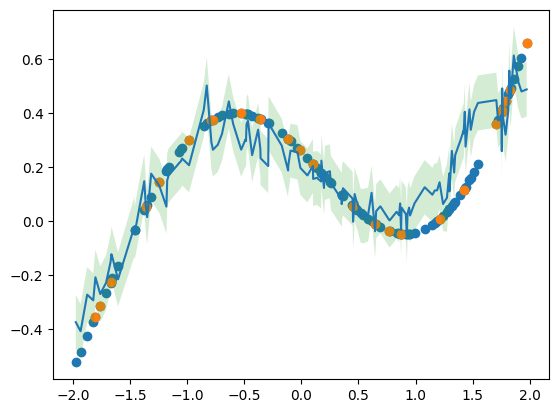

In [69]:
index_of_interest = 30
plt.scatter(x_target[index_of_interest], y_target[index_of_interest])
plt.scatter(x_context[index_of_interest], y_context[index_of_interest])

plt.plot(
    full_results[index_of_interest , full_results[index_of_interest , :, 0].argsort(), 0],
    full_results[index_of_interest , full_results[index_of_interest , :, 0].argsort(), 1]
)

plt.fill_between(
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 0],
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 2],
    full_results[index_of_interest ,full_results[index_of_interest ,:, 0].argsort(), 3],
    interpolate=True,
    alpha=0.2
)